In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import shape
from scipy import stats
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# A-B. Example raw traces

In [2]:
# Load data
from scipy.io import loadmat
idx = 0
data = loadmat('data/alpha.mat', struct_as_record=False, squeeze_me=True)
Fs = 500
f_range = (6, 14)
xC_raw = data['oz_rest_data']
xO_raw = data['oz_trial_data']
tC = np.arange(0, len(xC_raw)/Fs, 1/Fs)
tO = np.arange(0, len(xO_raw)/Fs, 1/Fs)

# Apply broad bandpass filter
f_bandpass = (2, 50)
filter_seconds = (2, .3)
xC = neurodsp.filter(xC_raw, Fs, 'highpass', f_hi=f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
xC = neurodsp.filter(xC, Fs, 'lowpass', f_lo=f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

xO = neurodsp.filter(xO_raw, Fs, 'highpass', f_hi=f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
xO = neurodsp.filter(xO, Fs, 'lowpass', f_lo=f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

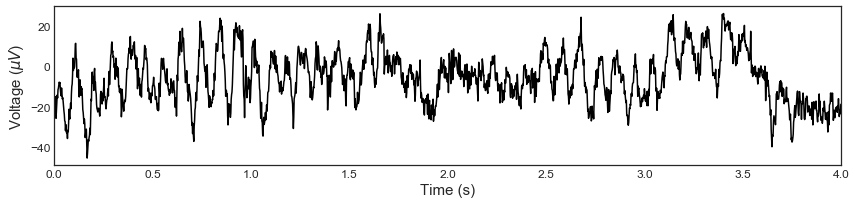

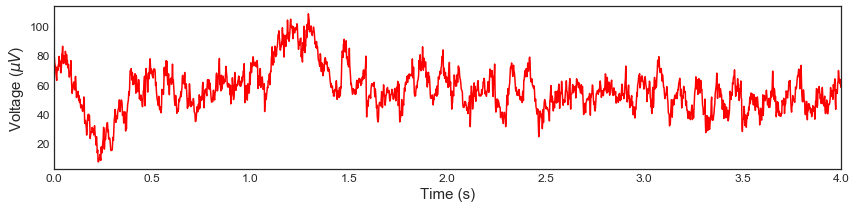

In [3]:
tlimC = np.array([5, 9])
tidxC = np.logical_and(tC >= tlimC[0], tC < tlimC[1])
plt.figure(figsize=(12,3))
plt.plot(tC[tidxC]-tlimC[0], xC_raw[tidxC], 'k')
plt.xlim(tlimC-tlimC[0])
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Voltage ($\mu V$)', size=15)
plt.xlabel('Time (s)', size=15)
plt.tight_layout()
plt.savefig('figs/10A_eyeclose_time_series.png')

tlimO = np.array([5, 9])
tidxO = np.logical_and(tO >= tlimO[0], tO < tlimO[1])
plt.figure(figsize=(12,3))
plt.plot(tO[tidxO]-tlimO[0], xO_raw[tidxO], 'r')
plt.xlim(tlimO-tlimO[0])
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylabel('Voltage ($\mu V$)', size=15)
plt.xlabel('Time (s)', size=15)
plt.tight_layout()
plt.savefig('figs/10B_eyeopen_time_series.png')

# C-F. Distributions of cycle features for DBS on and off

/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


volt_amp MannwhitneyuResult(statistic=47954.0, pvalue=3.9461694982354293e-62)
periodms MannwhitneyuResult(statistic=115668.0, pvalue=0.057009415331107441)
time_rdsym MannwhitneyuResult(statistic=114235.0, pvalue=0.028918680963600785)
time_ptsym MannwhitneyuResult(statistic=106937.0, pvalue=0.00021981682213466336)


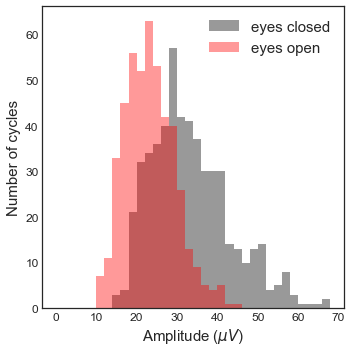

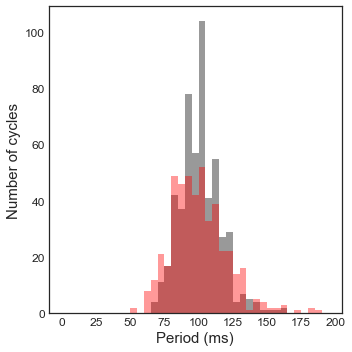

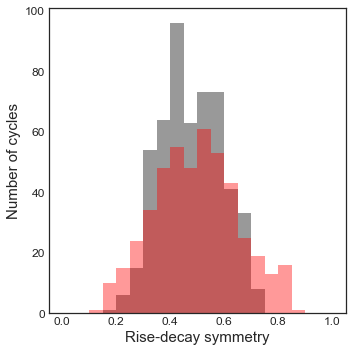

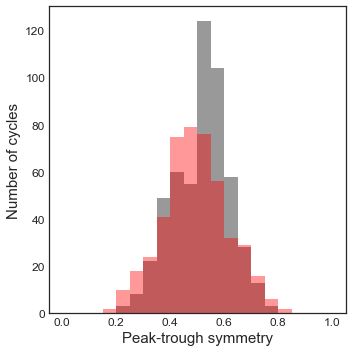

In [4]:
# Compute shape features and detect oscillating cycles
osc_kwargs = {'amplitude_fraction_threshold': .2,
              'amplitude_consistency_threshold': .3,
              'period_consistency_threshold': .5,
              'monotonicity_threshold': .6,
              'N_cycles_min': 3}
dfC = shape.features_by_cycle(xC, Fs, f_range, center_extrema='T', estimate_oscillating_periods=True,
                              estimate_oscillating_periods_kwargs=osc_kwargs)

dfO = shape.features_by_cycle(xO, Fs, f_range, center_extrema='T', estimate_oscillating_periods=True,
                              estimate_oscillating_periods_kwargs=osc_kwargs)

# Compute period in ms
dfC['periodms'] = dfC['period'] / Fs * 1000
dfO['periodms'] = dfO['period'] / Fs * 1000

# Make distributions of features, comparing DBS condition
feat_names = {'volt_amp': 'Amplitude ($\mu V$)',
              'periodms': 'Period (ms)',
              'time_rdsym': 'Rise-decay symmetry',
              'time_ptsym': 'Peak-trough symmetry'}
feat_figletter = {'volt_amp': 'C', 'periodms': 'D',
                  'time_rdsym': 'E', 'time_ptsym': 'F'}
feat_bins = {'volt_amp': np.arange(0, 70, 2),
             'periodms': np.arange(0, 200, 5),
             'time_rdsym': np.arange(0, 1.05, .05),
             'time_ptsym': np.arange(0, 1.05, .05)}

for feat, name in feat_names.items():
    print(feat, stats.mannwhitneyu(dfC[dfC['is_cycle']][feat], dfO[dfO['is_cycle']][feat]))
    plt.figure(figsize=(5,5))
    sns.distplot(dfC[dfC['is_cycle']][feat], bins=feat_bins[feat], 
                 color='k', kde=False, label='eyes closed')
    sns.distplot(dfO[dfO['is_cycle']][feat], bins=feat_bins[feat], 
                 color='r', kde=False, label='eyes open')
    if feat == 'volt_amp':
        plt.legend(fontsize=15)
    plt.ylabel('Number of cycles', size=15)
    plt.xlabel(name, size=15)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig('figs/10{:s}_{:s}_dist_eyes.png'.format(feat_figletter[feat], feat))